In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)
else:
    print("Running on CPU only")


PyTorch version: 2.5.1+cu118
CUDA available: True
GPU Name: NVIDIA GeForce RTX 3060
CUDA version: 11.8


In [2]:
import pandas as pd
import os

# Point to current folder since files are not in /data
DATA_DIR = "."

surface_files = {
    "Acrylic": "ACRYLIC_1.csv",
    "Bubblewrap_Back": "BUBBLEWRAP BACK_1.csv",
    "Bubblewrap_Front": "BUBBLEWRAP FRONT_1.csv",
    "Cardboard": "CARDBOARD_1.csv",
    "Glass": "GLASS_1.csv",
    "Glove": "GLOVE_1.csv",
    "Marble": "MARBLE_1.csv",
    "Metal": "METAL_1.csv",
    "Paper": "PAPER_1.csv",
    "Smooth_Wood": "SMOOTH WOODEN_1.csv"
}

merged_df = []

for surface, filename in surface_files.items():
    path = os.path.join(DATA_DIR, filename)
    df = pd.read_csv(path)

    df = df.rename(columns=lambda x: x.strip())
    if "Resistance" not in df.columns:
        df.columns = ["Time", "Resistance"] + [f"Unnamed_{i}" for i in range(2, len(df.columns))]
        
    df = df[["Time", "Resistance"]].dropna()
    df["Surface"] = surface
    merged_df.append(df)

all_data = pd.concat(merged_df, ignore_index=True)
print("Merged dataset shape:", all_data.shape)
all_data.head()



Merged dataset shape: (1687, 3)


,Time,Resistance,Surface
0,1,7254.73,Acrylic
1,2,7893.90,Acrylic
2,3,8091.35,Acrylic
3,4,8130.83,Acrylic
4,5,7933.59,Acrylic


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Parameters
WINDOW_SIZE = 20
STEP_SIZE = 1  # for sliding window
features = []
labels = []

# Encode surface labels
label_encoder = LabelEncoder()
all_data["SurfaceLabel"] = label_encoder.fit_transform(all_data["Surface"])

# Normalize resistance
scaler = MinMaxScaler()
all_data["ResistanceNorm"] = scaler.fit_transform(all_data[["Resistance"]])

# Group by surface and create windowed sequences
for surface, group in all_data.groupby("SurfaceLabel"):
    res = group["ResistanceNorm"].values
    for i in range(0, len(res) - WINDOW_SIZE, STEP_SIZE):
        window = res[i:i + WINDOW_SIZE]
        features.append(window)
        labels.append(surface)  # Assign the class for the whole sequence

X = np.array(features)
y = np.array(labels)

print("X shape:", X.shape)  # (num_samples, time_steps)
print("y shape:", y.shape)
print("Unique classes:", label_encoder.classes_)


X shape: (1487, 20)
y shape: (1487,)
Unique classes: ['Acrylic' 'Bubblewrap_Back' 'Bubblewrap_Front' 'Cardboard' 'Glass'
 'Glove' 'Marble' 'Metal' 'Paper' 'Smooth_Wood']


In [4]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# PyTorch Dataset
class SurfaceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SurfaceDataset(X_train_tensor, y_train_tensor)
test_dataset = SurfaceDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [5]:
import torch.nn as nn

class SurfaceLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, num_classes=10):
        super(SurfaceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(-1)  # shape: (batch, seq_len, 1)
        out, _ = self.lstm(x)  # out: (batch, seq_len, hidden)
        out = out[:, -1, :]    # take last timestep output
        out = self.fc(out)     # (batch, num_classes)
        return out

# Initialize model
model = SurfaceLSTM()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [6]:
# Training the model
EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 2.2864
Epoch [2/20], Loss: 2.2742
Epoch [3/20], Loss: 2.2784
Epoch [4/20], Loss: 2.2757
Epoch [5/20], Loss: 2.2712
Epoch [6/20], Loss: 2.2796
Epoch [7/20], Loss: 2.2708
Epoch [8/20], Loss: 2.1686
Epoch [9/20], Loss: 2.0474
Epoch [10/20], Loss: 2.0188
Epoch [11/20], Loss: 1.8928
Epoch [12/20], Loss: 1.8379
Epoch [13/20], Loss: 1.8376
Epoch [14/20], Loss: 1.8450
Epoch [15/20], Loss: 1.7245
Epoch [16/20], Loss: 1.7188
Epoch [17/20], Loss: 1.7087
Epoch [18/20], Loss: 1.6796
Epoch [19/20], Loss: 1.7092
Epoch [20/20], Loss: 1.6793


D:\SurfaceRecognitionModel\surface\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\SurfaceRecognitionModel\surface\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\SurfaceRecognitionModel\surface\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                  precision    recall  f1-score   support

         Acrylic       0.00      0.00      0.00        30
 Bubblewrap_Back       0.29      0.48      0.36        46
Bubblewrap_Front       0.00      0.00      0.00        25
       Cardboard       0.00      0.00      0.00        34
           Glass       0.00      0.00      0.00        20
           Glove       0.27      0.67      0.39        24
          Marble       0.82      0.51      0.63        35
           Metal       0.24      0.60      0.34        30
           Paper       0.40      0.95      0.57        22
     Smooth_Wood       0.00      0.00      0.00        32

        accuracy                           0.32       298
       macro avg       0.20      0.32      0.23       298
    weighted avg       0.22      0.32      0.24       298



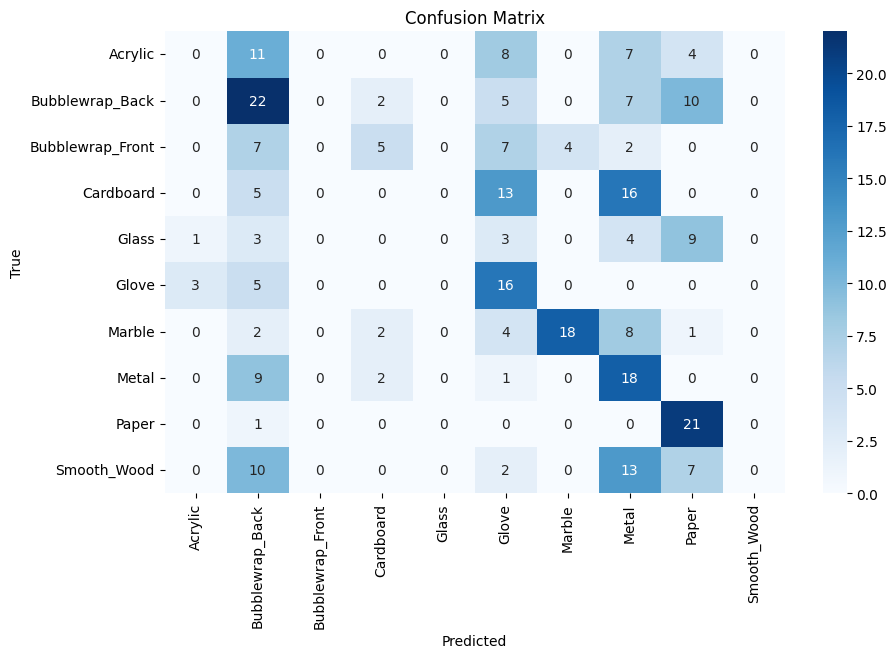

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

# Report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
